In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/data.csv')

# 1. Create tidy players table

In [13]:
player_index = 'playerShort'
player_col = [#'player', # drop player name, we have unique identifier
               'birthday',
               'height',
               'weight',
               'position',
               'photoID',
               'rater1',
               'rater2',
              ]

In [15]:
# Count unique variables
unique_players = df.groupby(player_index).agg({col:'nunique' for col in player_col})

In [18]:
# If all values are same per player 
unique_players[unique_players>1].dropna()

# If the dataframe is zero, meaning all player has only one record

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,


In [19]:
############### Use a function to do it ####################
def get_subgroup(dataframe, g_index, g_columns):
    """Helper function that creates a sub-table from the columns and runs a quick uniqueness test."""
    g = dataframe.groupby(g_index).agg({col:'nunique' for col in g_columns})
    if g[g > 1].dropna().shape[0] != 0:
        print("Warning: you probably assumed this had all unique values but it doesn't.")
    return dataframe.groupby(g_index).agg({col:'max' for col in g_columns})

In [21]:
players = get_subgroup(df, player_index, player_col)
players.head()

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25


# 2. Create tidy clubs and refs table

In [23]:
club_index = 'club'
club_col = ['leagueCountry']
clubs = get_subgroup(df,club_index, club_col)

In [24]:
ref_index = 'refNum'
ref_col = ['refCountry']
refs = get_subgroup(df,ref_index, ref_col)

In [26]:
country_index = 'refCountry'
country_cols = ['Alpha_3', # rename this name of country
                'meanIAT',
                'nIAT',
                'seIAT',
                'meanExp',
                'nExp',
                'seExp',
               ]
countries = get_subgroup(df, country_index, country_cols)
rename_columns = {'Alpha_3':'countryName', }
countries = countries.rename(columns=rename_columns)

In [27]:
dyad_index = ['refNum', 'playerShort']
dyad_cols = ['games',
             'victories',
             'ties',
             'defeats',
             'goals',
             'yellowCards',
             'yellowReds',
             'redCards',
            ]
dyads = get_subgroup(df, g_index=dyad_index, g_columns=dyad_cols)

# 3. Missing data

In [29]:
import missingno as msno

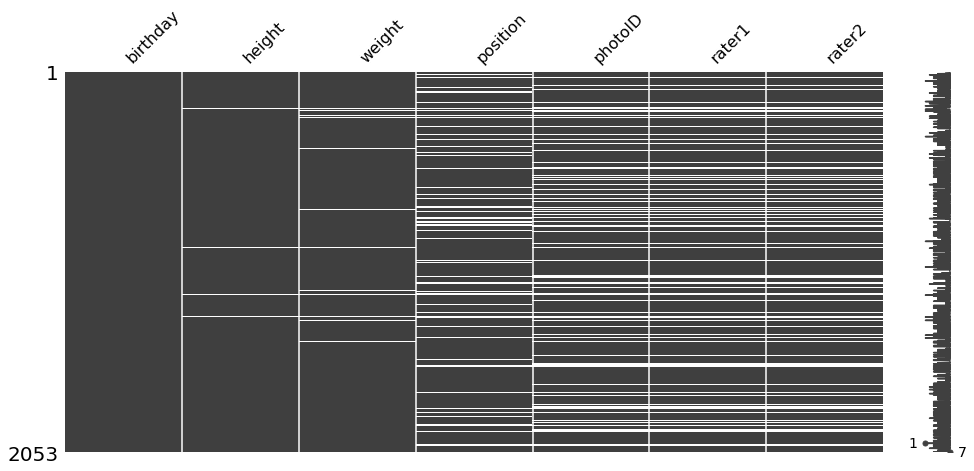

In [34]:
### Missing data for player table
msno.matrix(players.sample(2053),
            figsize=(16, 7),
            width_ratios=(20, 1))

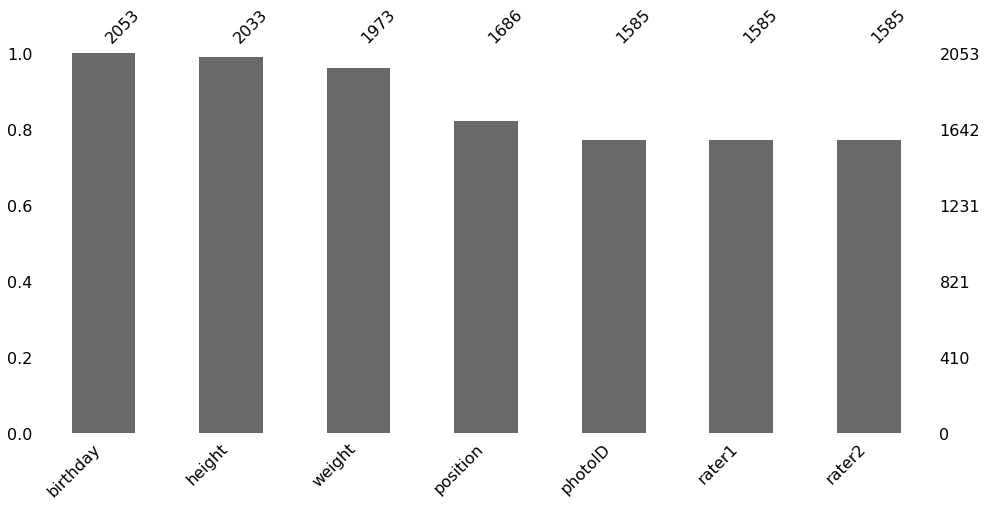

In [35]:
msno.bar(players.sample(2053),
            figsize=(16, 7),)

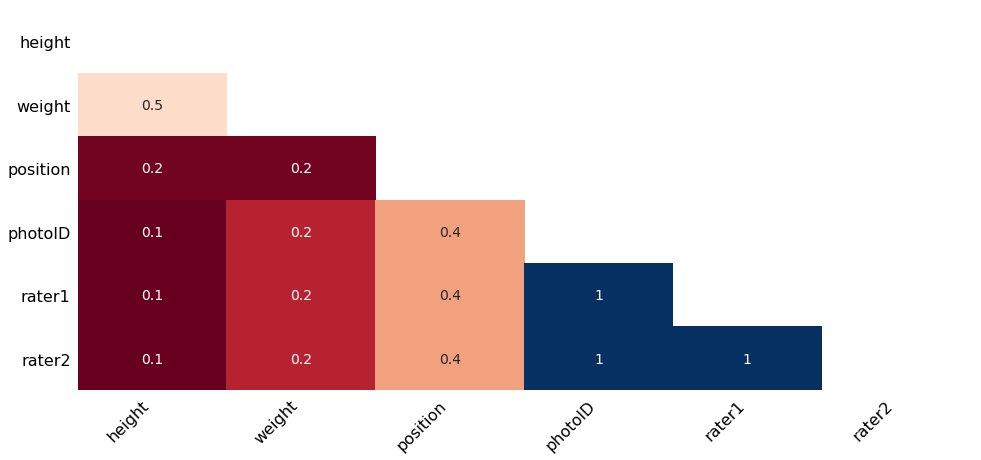

In [36]:
msno.heatmap(players.sample(2053),
            figsize=(16, 7),)

In [37]:
print("All players:", len(players))
print("rater1 nulls:", len(players[(players.rater1.isnull())]))
print("rater2 nulls:", len(players[players.rater2.isnull()]))
print("Both nulls:", len(players[(players.rater1.isnull()) & (players.rater2.isnull())]))

All players: 2053
rater1 nulls: 468
rater2 nulls: 468
Both nulls: 468


In [38]:
# modifying dataframe
players = players[players.rater1.notnull()]
players.shape[0]

1585

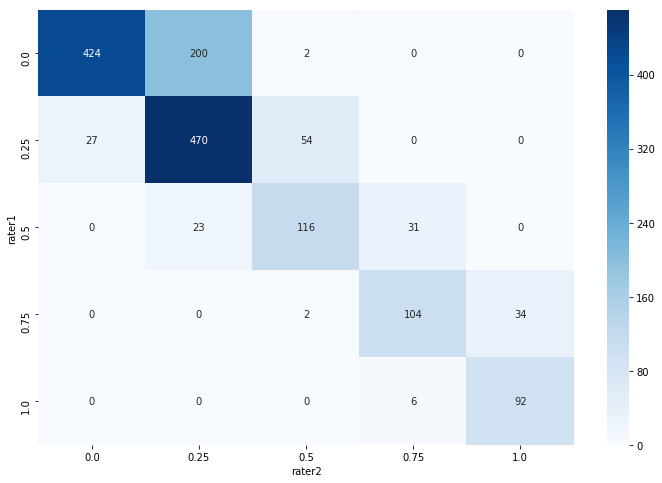

In [49]:
# Correlation between two raters
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize = (12,8))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap='Blues', annot=True, fmt='d')


In [50]:
# As the correlation is high, using the mean value
players['skintone'] = players[['rater1', 'rater2']].mean(axis=1)
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone
playerShort,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250


# Visualize univariate feature

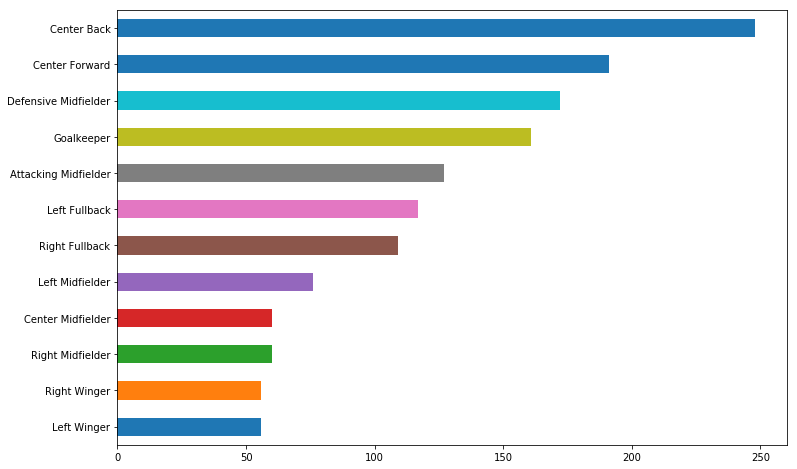

In [51]:
plt.figure(figsize = (12,8))
players.position.value_counts(dropna = True, ascending = True).plot(kind = 'barh')

# Higher level feature

In [52]:
### As different position may have different redcard rate
position_types = players.position.unique()

In [53]:
defense = ['Center Back','Defensive Midfielder', 'Left Fullback', 'Right Fullback', ]
midfield = ['Right Midfielder', 'Center Midfielder', 'Left Midfielder',]
forward = ['Attacking Midfielder', 'Left Winger', 'Right Winger', 'Center Forward']
keeper = 'Goalkeeper'

# modifying dataframe -- adding the aggregated position categorical position_agg
players.loc[players['position'].isin(defense), 'position_agg'] = "Defense"
players.loc[players['position'].isin(midfield), 'position_agg'] = "Midfield"
players.loc[players['position'].isin(forward), 'position_agg'] = "Forward"
players.loc[players['position'].eq(keeper), 'position_agg'] = "Keeper"

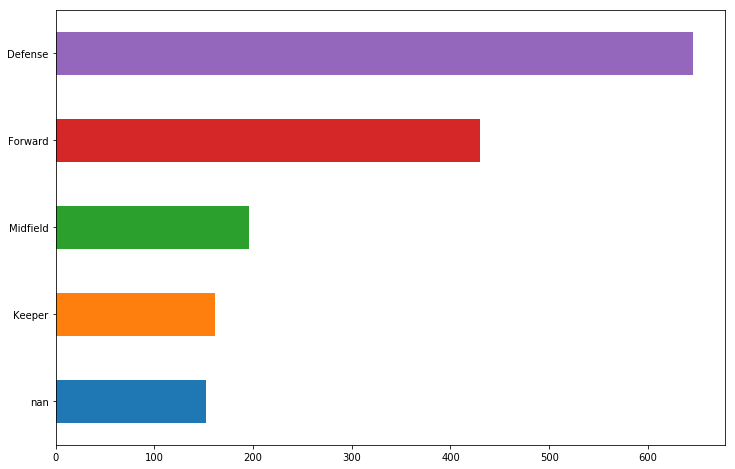

In [54]:
plt.figure(figsize = (12,8))
players.position_agg.value_counts(dropna=False, ascending= True).plot(kind = 'barh')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


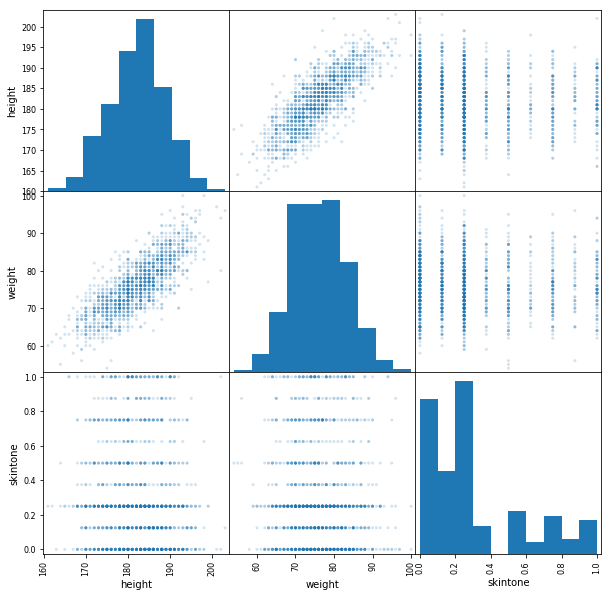

In [55]:
from pandas.tools.plotting import scatter_matrix
fig, ax = plt.subplots(figsize=(10, 10))
scatter_matrix(players[['height', 'weight', 'skintone']], alpha=0.2, diagonal='hist', ax=ax);

In [57]:
### For Continuous variables
# Weight
weight_categories = ["vlow_weight",
                     "low_weight",
                     "mid_weight",
                     "high_weight",
                     "vhigh_weight",
                    ]

players['weightclass'] = pd.qcut(players['weight'],
                                 len(weight_categories),
                                 weight_categories)
# Height
height_categories = ["vlow_height",
                     "low_height",
                     "mid_height",
                     "high_height",
                     "vhigh_height",
                    ]

players['heightclass'] = pd.qcut(players['height'],
                                 len(height_categories),
                                 height_categories)
# Skintone
players['skintoneclass'] = pd.qcut(players['skintone'], 3)

In [59]:
players.skintoneclass.value_counts()

(-0.001, 0.125]    651
(0.125, 0.25]      472
(0.25, 1.0]        462
Name: skintoneclass, dtype: int64

# Pandas Profiling

In [61]:
import pandas_profiling

In [62]:
pandas_profiling.ProfileReport(players)

Number of variables,13
Number of observations,1585
Total Missing (%),1.7%
Total size in memory,129.0 KiB
Average record size in memory,83.3 B
Numeric,3
Categorical,5
Boolean,0
Date,0
Text (Unique),2
Rejected,2


# Data Sanity Check

In [64]:
# Test if the number of games is equal to the victories + ties + defeats in the dataset
all(dyads['games'] == dyads.victories + dyads.ties + dyads.defeats)


True

In [65]:
dyads['totalRedCards'] = dyads['yellowReds'] + dyads['redCards']
dyads.rename({'redCards':'directReds'},inplace = True)

In [97]:
player_dyads = (players.merge(dyads.reset_index().set_index('playerShort'),
                             left_index = True, right_index = True))
player_dyads.reset_index().set_index(['refNum','playerShort'])

,,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg,weightclass,...,skintoneclass,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,totalRedCards
refNum,playerShort,,,,,,,,,,,,,,,,,,,,,
4,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,0,0,1,0,0,0,0,0
66,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
77,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",26,13,8,5,0,0,0,0,0
163,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",2,1,1,0,0,0,0,0,0
194,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",16,3,5,8,0,2,0,0,0
233,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",10,3,4,3,0,2,0,0,0
237,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
238,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
256,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",10,4,4,2,0,0,0,0,0


In [96]:
player_dyads.reset_index().set_index(['refNum','playerShort'])

,,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg,weightclass,...,skintoneclass,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,totalRedCards
refNum,playerShort,,,,,,,,,,,,,,,,,,,,,
4,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,0,0,1,0,0,0,0,0
66,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
77,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",26,13,8,5,0,0,0,0,0
163,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",2,1,1,0,0,0,0,0,0
194,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",16,3,5,8,0,2,0,0,0
233,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",10,3,4,3,0,2,0,0,0
237,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
238,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",1,1,0,0,0,0,0,0,0
256,aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.0,0.125,Defense,low_weight,...,"(-0.001, 0.125]",10,4,4,2,0,0,0,0,0


In [98]:
col_names = ['games','totalRedCards']
j = 0
out = [0 for _ in range (sum(player_dyads['games']))]

for index,row in player_dyads.reset_index().iterrows():
    n = row['games']
    d = row['totalRedCards']
    ref = row['refNum']
    player = row['playerShort']
    for _ in range(n):
        row['totalRedCards'] = 1 if (d-_)>0 else 0
        rowlist = list([ref,player,row['totalRedCards']])
        out[j] = rowlist
        j+=1
tidy_dyads = pd.DataFrame(out, columns = ['refNum','playerShort',
                                         'redcard'],).set_index(['refNum','playerShort'])

In [99]:
tidy_dyads

redcard
refNum playerShort          
4      aaron-hughes        0
66     aaron-hughes        0
77     aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
       aaron-hughes        0
163    aaron-hughes        0
       aaron-hughes        0
...                      ...
1559   zurutuza            0
       zurutuza            0
1574   zurutuza            0
1886   zurutuza            0
       zurutuza            0
       zurutuza            0
2063   zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
2099   zurutuza            0
2176   zurutuza            0
2356   zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
       zurutuza            0
2449   zurutuza            0
       zurutuza            0
2639   zurutuza            0
2690   zurutuza            0
3012   zurutuza            0

[373067 rows x 1 columns]